# Retrieve Snow Water Equivalent data from the National Water Model

Author: Irene Garousi-Nejad <br>
Last updated: Feb 27, 2024

This notebook shows how to access the National Water Model version 3 retrospective simulated data, in particular, the snow water equivalent. Data is stored on AWS and can be accessed through the following link. Thsi notebook has been tested on the CIROH 2i2c Cloud infrastructure. The printed computation times correspond to a **Medium server**, with 11GB of RAM and 4 CPUs. 

Funding Resources:

<img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">     <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/IGUIDE_logoH_ColorMulti.png" width="200" height="20">     <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300">

## 1. Import libraries, set up Dask, Define function and parameters

In [1]:
import os
import s3fs
import boto3
import fsspec
import pandas as pd
import numpy as np
import xarray as xr
import zarr
import glob
import rasterio
import pyproj
import geopandas
import matplotlib.pyplot as plt

In [3]:
import dask
from dask.distributed import Client
from dask.distributed import progress
try:
    print(client.dashboard_link)
except:    
    client = Client(n_workers=24, threads_per_worker=1, memory_limit='2GB') 
    print(client.dashboard_link)

/user/igarousi/proxy/36789/status


#### Functions used in this notebook:

In [4]:
def convert_latlon_to_yx(lat, lon, input_crs, output_crs):
    """
    This function takes latitude and longitude values along with
    input and output coordinate reference system (CRS) and 
    uses Python's pyproj package to convert the provided values 
    (as single float values, not arrays) to the corresponding y and x 
    coordinates in the output CRS.
    
    Parameters:
    lat: The latitude value
    lon: The longitude value
    input_crs: The input coordinate reference system ('EPSG:4326')
    output_crs: The output coordinate reference system
    
    Returns:
    y, x: a tuple of the transformed coordinates in the specified output
    """
    # Create a transformer
    transformer = pyproj.Transformer.from_crs(input_crs, output_crs, always_xy=True)

    # Perform the transformation
    x, y = transformer.transform(lon, lat)

    return y, x 


def save_geotiff(raster, outname):
    """ 
    This function takes a 2-D xarray dataset from the NWM land surface model outputs
    and saves it as a geotiff file with the correct origin information
    so it can be displayed correctly on geographical maps. 
    
    Parameters:
    raster: a 2-D xarray dataset 
    outname: The path and name to save the geotif
    
    Returns:
    The output is saved as a geotiff file
    """
    coords = raster.coords    
    # Adding -/+500 is because the x and y valuse in the netcdf file are center coordiantes
    # for each grid. For defining the origin, we need the corner coordiantes. 
    # Since we already know the cell size is 1000, half of it is 500 m and we consider that
    # to compute the corner coordinates from the center coornidates.
    geo_transform = rasterio.transform.from_origin(float(ds_subset.x.min().values)-500, 
                                                   float(ds_subset.y.min().values)-500,
                                                   1000,
                                                   -1000)
   
    # Create a GeoTIFF file
    with rasterio.open(outname, 'w', driver='GTiff', 
                       height=raster.shape[0], 
                       width=raster.shape[1],
                       count=1, dtype=raster.dtype, 
                       crs=raster.esri_pe_string , 
                       transform=geo_transform,
                       compress='LZW') as dst:
        dst.write(raster, 1) 

#### User defined parameters:

In [5]:
# NWM data link. This is the link to the LDASOUT outputs over the CONUS in the Zarr format
conus_bucket_url = 's3://noaa-nwm-retrospective-3-0-pds/CONUS/zarr/ldasout.zarr'

# SNOTEL gage
gage_id = 677
gage_lon = -112.12515
gage_lat = 42.26015

# Path to the HUC12 shapefile associated with the SNOTEL gage
huc12 = './huc12_160102040205.shp'

## 2. Load the NWM retrospective runs 

Use Xarray to load the metadata, not the actual data, into the memory.

In [6]:
%%time

ds = xr.open_zarr(
        fsspec.get_mapper(
            conus_bucket_url,
            anon=True
        ),
        consolidated=True
)

ds

CPU times: user 8.46 s, sys: 1.53 s, total: 9.99 s
Wall time: 42.8 s


<xarray.Dataset>
Dimensions:   (time: 128568, y: 3840, x: 4608, vis_nir: 2, soil_layers_stag: 4)
Coordinates:
  * time      (time) datetime64[ns] 1979-02-01T03:00:00 ... 2023-02-01
  * x         (x) float64 -2.303e+06 -2.302e+06 ... 2.303e+06 2.304e+06
  * y         (y) float64 -1.92e+06 -1.919e+06 ... 1.918e+06 1.919e+06
Dimensions without coordinates: vis_nir, soil_layers_stag
Data variables: (12/21)
    ACCET     (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ACSNOM    (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ALBEDO    (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ALBSND    (time, y, vis_nir, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    ALBSNI    (time, y, vis_nir, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    COSZ      (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    ...        ...
    SNOWH     (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    SOIL_M    (time, y, soil_layers_stag, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    SOIL_W    (time, y, soil_layers_stag, x) float64 dask.array<chunksize=(224, 350, 1, 350), meta=np.ndarray>
    TRAD      (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    UGDRNOFF  (time, y, x) float64 dask.array<chunksize=(224, 350, 350), meta=np.ndarray>
    crs       |S1 ...
Attributes:
    Conventions:          CF-1.6
    GDAL_DataType:        Generic
    NCO:                  netCDF Operators version 5.1.4 (Homepage = http://n...
    TITLE:                OUTPUT FROM WRF-Hydro v5.3.0-alpha1
    code_version:         v5.3.0-alpha1
    history:              Thu Sep 28 08:10:06 2023: ncatted -O -a missing_val...
    model_configuration:  retrospective
    model_output_type:    land
    proj4:                +proj=lcc +units=m +a=6370000.0 +b=6370000.0 +lat_1...

## 3. Identify the NWM grid cell containing the given SNOTEL gage

Given the provided latitude and longitude values for a specific SNOTEL gage location, we aim to find the corresponding y and x coordinates of a grid cell within the NWM. Here, we are using the `convert_latlon_to_yx` function, defined in the first section of this notebook.

In [7]:
input_crs = 'EPSG:4269'
output_crs = pyproj.CRS(ds.crs.esri_pe_string) 

snotel_y, snotel_x = convert_latlon_to_yx(gage_lat, gage_lon, input_crs, output_crs)

print(gage_lat, gage_lon)
print(snotel_y, snotel_x)

42.26015 -112.12515
356780.08357964037 -1196747.3024150904


Create a shapefile for the SNOTEL gage for the visualization purposes

In [8]:
import geopandas as gpd
from shapely.geometry import Point

# Sample data (replace with your actual latitude and longitude values)
data = {'Latitude': [gage_lat],
        'Longitude': [gage_lon]}

# Create a GeoDataFrame with Point geometries
geometry = [Point(lon, lat) for lon, lat in zip(data['Longitude'], data['Latitude'])]
gdf = gpd.GeoDataFrame(data, geometry=geometry, crs=input_crs)  

# Save to a shapefile
output_shapefile_path = f'./snotel_gage_{gage_id}.shp'
gdf.to_file(output_shapefile_path, driver='ESRI Shapefile')


## 4. Retrieve data for the identified grid associated with the SNOTEL gage

### 4.1. Create a subset representing a buffer region around the SNOTEL gage location. 

Here is what happens in the following code cell: To create subsets of an xarray dataset, we often use `.sel()` based on defined dimensions. However, it's important to note that `.sel()` doesn't function for coordinates that aren't part of dimensions. In our example, we aim to create a subset based on 'y' and 'x', which are both coordinates and dimensions. To establish a range within a dimension, we use `.slice()`. Additionally, when retrieving values based on a given index rather than a specific value, we turn to `.isel()`. By using `.compute()`, we instruct Dask to use its workers, set up in the first section, to execute tasks. We time these operations to evaluate the computational load.

The final important point is to ensure that the subset results have dimensions when using `.sel()` to prevent future errors related to saving as geotiff or for visualization. Thus, instead of `ds.SNEQV.sel()`, we opt for `ds[['SNEQV']].sel()`, ensuring the presence of dimensions. 

I used a 1000-meter buffer. So, by using `snotel_y-1000` and `snotel_y+1000`, we are defining a domain that extends approximately 1000 meters beyond and around the 'snotel_y' value. 

In [9]:
%%time
ds_subset = ds[['SNEQV']].sel(y=slice(snotel_y-1000, snotel_y+1000), x=slice(snotel_x-1000, snotel_x+1000)).isel(time=0).compute()

CPU times: user 538 ms, sys: 199 ms, total: 736 ms
Wall time: 2.1 s


The following code uses the xarray's underlying plotting functionality (default is Matplotlib) to plot the map.

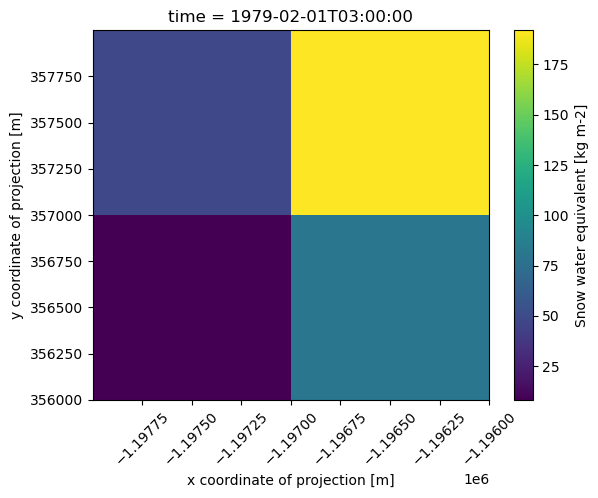

In [10]:
# Simple plot
ds_subset.SNEQV.plot()
plt.xticks(rotation=45)
plt.show()

In [ ]:
# # Save as a netcdf
######### BUG. This is not working correctly when opened in the QGIS. 
# ds_subset.to_netcdf(f'./subset_buffer_for_snotel_{gage_id}.nc')

In [11]:
# Save a a geotiff for visualization purposes
save_geotiff(ds_subset.SNEQV, f'./subset_buffer_for_snotel_{gage_id}.tif')

Plot both the shapefile and the map using cartopy. First we read the raster and then shapefiles.

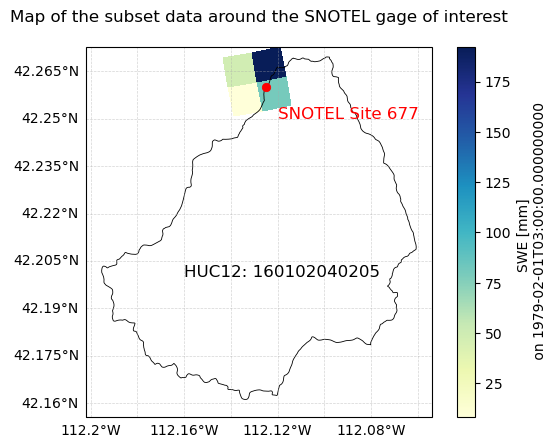

In [13]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Open the raster file
with rasterio.open(f'./subset_buffer_for_snotel_{gage_id}.tif') as src:
    # Read the data and the affine transformation
    data = src.read(1)  # Assuming it's a single-band raster
    transform = src.transform

# Get the coordinates of the raster
height, width = data.shape
x = np.arange(0, width) * transform[0] + transform[2]
y = np.arange(0, height) * transform[4] + transform[5]

# The following x and y correction is very important for data visualization. 
# Previously, we subtracted 500 meters from the minimum y and x values in the subset section.
# That was because the NWM x and y values represent the center, not the corners. 
# For cartopy, we need corner values to correctly map data.
x = x+500
y = y+500

# Create a meshgrid of coordinates
lon, lat = np.meshgrid(x, y)

# Specify the projection of the original raster (replace with your actual projection)
original_crs = src.crs

# Define the target projection as PlateCarree (lat-long)
target_crs = ccrs.PlateCarree()

# Convert rasterio CRS to Cartopy CRS
from cartopy import crs as ccrs
target_crs_cartopy = ccrs.Projection(original_crs)

# Use Cartopy to plot the raster
fig, ax = plt.subplots(subplot_kw={'projection': target_crs})
img = ax.pcolormesh(lon, lat, data, transform=target_crs_cartopy, cmap='YlGnBu')

# Add coastlines or other map features if needed
ax.coastlines()

# Add gridlines
gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='darkgray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# # Plot the domain. Orders matter. 
shp_huc12 = geopandas.read_file(huc12)
shp_huc12.plot(ax=ax, facecolor='none', edgecolor='k', linewidth=0.6)
shp_snotel = geopandas.read_file(f'./snotel_gage_{gage_id}.shp') 
shp_snotel.plot(ax=ax, facecolor='red', edgecolor='red', linewidth=0.6)

# Add text
plt.text(-112.12,42.25, f'SNOTEL Site {gage_id}', fontsize=12, color='r')
plt.text(-112.16,42.20, f'HUC12: {shp_huc12.huc12[0]}', fontsize=12, color='k')

# Add title
plt.title('Map of the subset data around the SNOTEL gage of interest\n', fontsize=12)

# Add colorbar
# Cartopy itself does not provide a direct way to add color bars (cbar) because it focuses on cartographic projections
# So, use Matplotlib.
cbar = plt.colorbar(img, ax=ax, orientation='vertical')
cbar.set_label(f'SWE [mm] \n on {str(ds_subset.SNEQV.time.values)}') # or str(pd.to_datetime(ds_subset.SNEQV.time.values).date())

# Show the plot
plt.show()

Let's verify with the visualization in QGIS. The following image shows the subset data overlayed by the CONUS-wide data. The base map is ESRI Topo map and is used to confirm that the location of the Upper Deep Creek HUC12 and the subset data is correct.

<img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/validation-img/subset-swe-snotel-677.png" width="500" height="500">   

### 4.2. Create a subset representing a geolocation and plot timeseries

We will use the `nearest` selection method to select a subset of the data based on the nearest coordinate values to the specified snotel_y and snotel_x coordinates. Note that we are retrieving SWE data for all the simulated time steps.

In [14]:
%%time
ds_subset = ds[['SNEQV']].sel(y=snotel_y, x=snotel_x, method='nearest').compute()


CPU times: user 7.56 s, sys: 2.38 s, total: 9.95 s
Wall time: 1min 8s


In [15]:
# print the number of time steps
print('\n', f'Start: {ds_subset.time[0].values}, End: {ds_subset.time[-1].values}', '\n', 
      f'Number of every 3 hours: {len(ds_subset.time)} ')


 Start: 1979-02-01T03:00:00.000000000, End: 2023-02-01T00:00:00.000000000 
 Number of every 3 hours: 128568 


#### Plot the hourly SWE timeseries over the entire period

Note that simulation period is hourly, but the outputs are reported every 3 hours. 

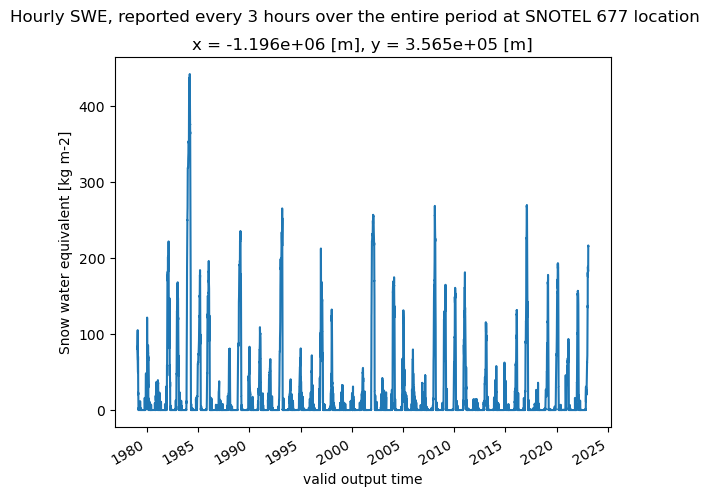

In [16]:
ds_subset.SNEQV.plot()
plt.suptitle(f'Hourly SWE, reported every 3 hours over the entire period at SNOTEL {gage_id} location')
plt.show()

#### Save as CSV

In [18]:
%%time
hourly_data = ds_subset.to_dataframe()
hourly_data.to_csv(f'swe_at_snotel_{gage_id}.csv')
hourly_data

CPU times: user 599 ms, sys: 27.5 ms, total: 626 ms
Wall time: 714 ms


,SNEQV,x,y
time,,,
1979-02-01 03:00:00,80.600001,-1196499.125,356499.65625
1979-02-01 06:00:00,81.900001,-1196499.125,356499.65625
1979-02-01 09:00:00,82.800001,-1196499.125,356499.65625
1979-02-01 12:00:00,83.400001,-1196499.125,356499.65625
1979-02-01 15:00:00,83.800001,-1196499.125,356499.65625
...,...,...,...
2023-01-31 12:00:00,215.700003,-1196499.125,356499.65625
2023-01-31 15:00:00,215.700003,-1196499.125,356499.65625
2023-01-31 18:00:00,215.700003,-1196499.125,356499.65625


#### Plot the monthly mean SWE timeseries over the entire period 

In [19]:
%%time
# Group by month
grouped_data = ds_subset.SNEQV.groupby('time.month')

# Calculate monthly averages, min, max, and median
monthly_means = grouped_data.mean(dim='time')
monthly_mins = grouped_data.min(dim='time')
monthly_maxs = grouped_data.max(dim='time')

CPU times: user 154 ms, sys: 7.94 ms, total: 162 ms
Wall time: 147 ms


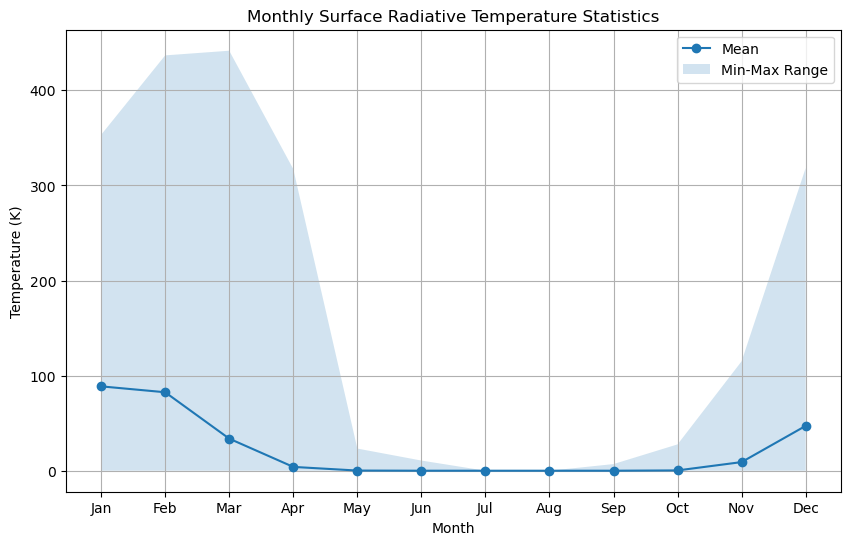

In [20]:
fig, ax = plt.subplots(figsize=(10, 6))

# Plot monthly averages
monthly_means.plot.line(ax=ax, marker='o', label='Mean')

# Plot min, max, and median
ax.fill_between(monthly_means.month, monthly_mins, monthly_maxs, alpha=0.2, label='Min-Max Range')

plt.xlabel('Month')
plt.ylabel('Temperature (K)')
plt.title('Monthly Surface Radiative Temperature Statistics')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

plt.legend()
plt.grid(True)
plt.show()


#### Save as CSV

In [21]:
%%time
monthly_means_data = monthly_means.to_dataframe()
monthly_means_data.to_csv(f'_monthly_mean_swe_at_snotel_{gage_id}.csv')
monthly_means_data

CPU times: user 8.92 ms, sys: 971 µs, total: 9.89 ms
Wall time: 54.3 ms


,y,x,SNEQV
month,,,
1,356499.65625,-1196499.125,88.704483
2,356499.65625,-1196499.125,82.505200
3,356499.65625,-1196499.125,33.728235
4,356499.65625,-1196499.125,4.017102
5,356499.65625,-1196499.125,0.168851
6,356499.65625,-1196499.125,0.011761
7,356499.65625,-1196499.125,0.000000
8,356499.65625,-1196499.125,0.000000
9,356499.65625,-1196499.125,0.006354


## 5. Retrieve data for a catchment encompassing a SNOTEL gage

TODO